                                                                Project "AI Method For Business"

For the course 'AI Method for Business' the students of the master Digital Driven Business have developed different machine learning tools to answer the following research question: 

### Which (Characteristics of) movies should a cinema screen to maximize ticket sales?

In this Notebook you can find the code for the Random Forest and kNN model written by Viktor. 
The students who participated in this study are: 

* Ward Bleeker          500805826
* Victor Varga          500913660
* Guido Huiskens        500685026
* Melanie Matt          500737939


## Import all libraries 

According to Medium (2022), the EDA (Exploratory of Data Analysis) is an essential step. It allows researchers to understand the data and clean it, so it is ready for analysis.

In [168]:
# Import libraries for data manipulation. Adjusted from Dauhmik (n.d.). 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
from numpy.random import randn

# Import libraries for data visualization. Adjusted from Medium (2022) 
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from plotnine import *

# Import libaries for modelling KNN. Adjusted from Pinosio (2022) 
from sklearn import datasets
from typing import List

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # The term 'all' is used to make jupyter print all outputs and not only the last one. 
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import f1_score
#from plotnine import * #import fails

#Kmeans library  
import random
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
#!pip install yellowbrick 
from yellowbrick.cluster import KElbowVisualizer  # pip install yellowbrick for the Elbow method


### EDA: Import Excel file and clean dataset

In [169]:
# Import Excel file Metaclean and show the beginning of the dataset. - Melanie, Viktor, Guido & Ward 
# Read Excel file Sales show the beginning of the dataset. - Melanie, Viktor, Guido & Ward 
df_metaclean = pd.read_csv('C:/Users/ayoft/Desktop/DDB/AI Methods for Business/Project/Raw datasets/metaClean43Brightspace.csv', encoding='ISO-8859-1')
df_sales = pd.read_csv('C:/Users/ayoft/Desktop/DDB/AI Methods for Business/Project/Raw datasets/sales.csv', encoding='ISO-8859-1')

In [170]:
# Merge sales data set with metaclean
df_masterfile = df_metaclean.merge(df_sales,
                            on="title",
                            how='left')

#df_masterfile['ï»¿url'] = df_masterfile['ï»¿url'].astype('str')
#df_masterfile.dtypes
#df_masterfile.drop_duplicates(subset=['ï»¿url'],inplace=True,keep='last')
#df_masterfile

#COMMENT THIS IT'S ONLY FOR ME - VIKTOR

df_masterfile['url_x'] = df_masterfile['url_x'].astype('str')
#df_masterfile.dtypes
df_masterfile.drop_duplicates(subset=['url_x'],inplace=True,keep='last')
df_masterfile['creative_type'].unique()

array([nan, 'Contemporary Fiction', 'Kids Fiction', 'Dramatization',
       'Historical Fiction', 'Factual', 'Science Fiction', 'Fantasy',
       'Multiple Creative Types', 'Super Hero'], dtype=object)

#### Drop columns:
Director, international box office, domestic box office, movie title, summary, cast and url columns will be removed because they will not be used for predictions. In addition, the Unnamed: 8 

In [172]:
# Drop columns that are not necessary 

df_masterfile.drop(columns=['summary', 'director','cast', 'url_x', 'Unnamed: 8', 'url_y', 'title', 'keywords', 'creative_type','domestic_box_office', 'international_box_office'], inplace=True)

### Corelation

In [173]:
# Show corelation of the dataset
corelation= df_masterfile.corr()
print(corelation)

                      runtime_x  metascore  userscore      year  \
runtime_x              1.000000   0.129545   0.157995  0.013624   
metascore              0.129545   1.000000   0.485050  0.137641   
userscore              0.157995   0.485050   1.000000 -0.150152   
year                   0.013624   0.137641  -0.150152  1.000000   
worldwide_box_office   0.252414   0.033516   0.073545 -0.042967   
production_budget      0.376848   0.011570   0.006131  0.110637   
opening_weekend        0.273979  -0.043457   0.007683  0.040876   
theatre_count          0.216186  -0.300981  -0.156670  0.028943   
avg run per theatre    0.097385   0.278328   0.223441 -0.273840   
runtime_y              0.926454   0.117023   0.184411 -0.034094   

                      worldwide_box_office  production_budget  \
runtime_x                         0.252414           0.376848   
metascore                         0.033516           0.011570   
userscore                         0.073545           0.006131   
ye

<AxesSubplot:>

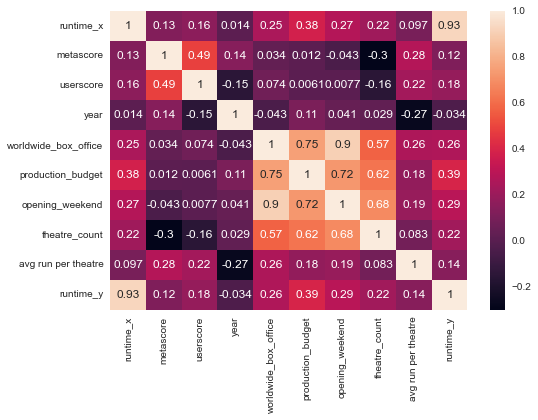

In [174]:
# Show corelation by using the heatmap function
#plt.figure(figsize=(16,16))
sns.heatmap(corelation, xticklabels=corelation.columns, yticklabels=corelation.columns,annot=True)

plt.show()

The heatmap above presents the following information; 

negative correlation between the columns:
- worldwide box office and year, 

a strong correlation between 
- worldwide box office and opening weekend;
- worldwide box office and production budget

and a correlation between
- worldwide box office and theatre count. 

In [175]:
# missing values overview per feature. Adjusted from DataSciencePartners (2022).
for column in df_masterfile.columns:
    amount_missing = np.sum(df_masterfile[column].isnull()) #This was in Dutch so I translated it to ENG don't mind me
    print('{} - {}'.format(column, amount_missing))

studio - 350
rating - 1067
runtime_x - 255
genre_x - 20
awards - 6977
metascore - 0
userscore - 2105
RelDate - 0
year - 3007
release_date - 3007
genre_y - 3379
worldwide_box_office - 5989
production_budget - 7892
opening_weekend - 4746
theatre_count - 4728
avg run per theatre - 4732
runtime_y - 4672


In [176]:
# Drop columns that are not correlated with worldwide box office or miss to many values. 
df_masterfile.drop(columns=['production_budget', 'awards', 'avg run per theatre', 'release_date'], inplace=True)
# Check if the above mentioned columns are removed from the dataset. 
# df_masterfile

In [177]:
# Show only columns that includes data for worldwide box office - Viktor
df_cleaned =df_masterfile[df_masterfile['worldwide_box_office'].notna()]
df_cleaned

,studio,rating,runtime_x,genre_x,metascore,userscore,RelDate,year,genre_y,worldwide_box_office,opening_weekend,theatre_count,runtime_y
1,Paramount Pictures,| PG-13,104.0,"Action,Sci-Fi,Drama,Mystery,Thriller,Horror",76,7.7,11/03/2016,2016.0,Thriller/Suspense,1.082864e+08,24727437.0,3391.0,103.0
3,Anchor Bay Entertainment,| R,100.0,"Drama,Comedy,Romance",61,6.9,14/09/2012,2012.0,Drama,9.876400e+05,22707.0,3.0,100.0
5,Samuel Goldwyn Films,NaN,93.0,Drama,44,6.1,13/01/2017,2016.0,Drama,3.070000e+02,NaN,NaN,93.0
9,Kino Lorber,| Not Rated,93.0,Drama,65,NaN,08/05/2015,2015.0,Drama,4.701900e+04,NaN,NaN,88.0
12,THINKFilm,| R,107.0,"Drama,Mystery,Thriller,Crime",36,6.7,18/08/2006,2006.0,Drama,1.437820e+05,20774.0,6.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11989,Paramount Pictures,| R,89.0,Comedy,61,7.2,28/09/2001,2001.0,Comedy,6.078098e+07,15525043.0,2507.0,89.0
11990,Paramount Pictures,| PG-13,102.0,Comedy,34,4.1,12/02/2016,2016.0,Comedy,5.534869e+07,13841146.0,3394.0,102.0
11992,Columbia Pictures,| PG,83.0,"Action,Adventure,Sci-Fi,Family",26,4.4,11/08/2006,2006.0,Adventure,1.250619e+07,4510408.0,2501.0,NaN
11994,Screen Media Films,| Not Rated,96.0,"Drama,Comedy,Animation",55,5.7,02/09/2016,2006.0,Adventure,1.250619e+07,4510408.0,2501.0,NaN


In [178]:
# Change datatype worldwide box office into integer - Melanie, Viktor

df_cleaned["worldwide_box_office"] = df_cleaned["worldwide_box_office"].astype("float")
df_cleaned["worldwide_box_office"] = df_cleaned["worldwide_box_office"].astype("int")


C:\Users\ayoft\AppData\Local\Temp\ipykernel_28408\412134369.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ayoft\AppData\Local\Temp\ipykernel_28408\412134369.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [179]:
# Checking the amount of NaNs in dataset 
print('Printing total number of NaNs in the dataframe,', df_cleaned.isnull().sum().sum())

Printing total number of NaNs in the dataframe, 2745


d:\Anaconda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log


(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 5.125e+03,
        1.830e+02, 5.200e+01, 9.000e+00, 4.000e+00]),
 array([-2.14748365e+09, -1.72789931e+09, -1.30831497e+09, -8.88730627e+08,
        -4.69146287e+08, -4.95619470e+07,  3.70022393e+08,  7.89606733e+08,
         1.20919107e+09,  1.62877541e+09,  2.04835975e+09]),
 <BarContainer object of 10 artists>)

(array([   6.,   15.,   55.,  140.,  462.,  767.,  967., 1282., 1350.,
         329.]),
 array([ 2.48490665,  4.3804465 ,  6.27598636,  8.17152621, 10.06706607,
        11.96260592, 13.85814577, 15.75368563, 17.64922548, 19.54476534,
        21.44030519]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Original Data')

Text(0.5, 1.0, 'Transformed Data')

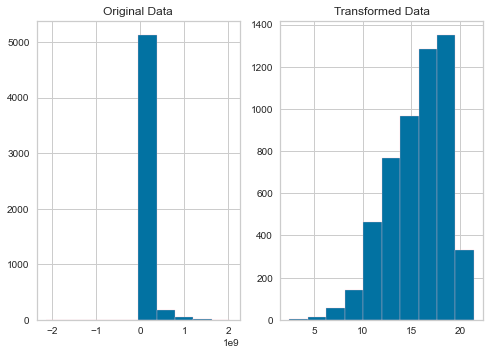

In [180]:
# Code adjusted from Business statistics project (Melanie) (2022). 
# create log-transformed data to check normality. 
data_log = np.log(df_cleaned["worldwide_box_office"]) 
data = df_cleaned["worldwide_box_office"]
# define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

#create histograms
axs[0].hist(data, edgecolor='pink')
axs[1].hist(data_log, edgecolor='pink')

#add title to each histogram
axs[0].set_title('Original Data')
axs[1].set_title('Transformed Data')

In [181]:
#Including a column with the log'd data in the original dataframe

df_cleaned['wbo_log'] = data_log

C:\Users\ayoft\AppData\Local\Temp\ipykernel_28408\1809161173.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


d:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='worldwide_box_office', ylabel='Density'>

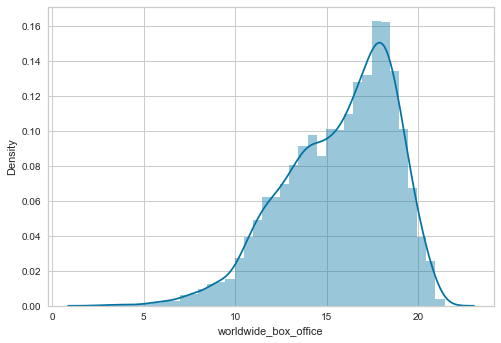

In [182]:
# Show distplot of worldwide box office after applying the log function 
sns.distplot(data_log)

In [183]:
# impute missing values. Code adjusted from Scikit-learn (2007). 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent',
                        missing_values=np.nan)
imputer = imputer.fit(df_cleaned)
df_cleaned.iloc[:,:] = imputer.transform(df_cleaned)
print()

C:\Users\ayoft\AppData\Local\Temp\ipykernel_28408\4228925242.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [184]:
#Transforming the user score column - Viktor

df_cleaned['userscore'] = df_cleaned['userscore'] * 10
df_cleaned['userscore'] = df_cleaned['userscore'].astype('int64')
df_cleaned

C:\Users\ayoft\AppData\Local\Temp\ipykernel_28408\1933024683.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ayoft\AppData\Local\Temp\ipykernel_28408\1933024683.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,studio,rating,runtime_x,genre_x,metascore,userscore,RelDate,year,genre_y,worldwide_box_office,opening_weekend,theatre_count,runtime_y,wbo_log
1,Paramount Pictures,| PG-13,104.0,"Action,Sci-Fi,Drama,Mystery,Thriller,Horror",76,77,11/03/2016,2016.0,Thriller/Suspense,108286422,24727437.0,3391.0,103.0,18.500290
3,Anchor Bay Entertainment,| R,100.0,"Drama,Comedy,Romance",61,69,14/09/2012,2012.0,Drama,987640,22707.0,3.0,100.0,13.803074
5,Samuel Goldwyn Films,| R,93.0,Drama,44,61,13/01/2017,2016.0,Drama,307,9134.0,4.0,93.0,5.726848
9,Kino Lorber,| Not Rated,93.0,Drama,65,71,08/05/2015,2015.0,Drama,47019,9134.0,4.0,88.0,10.758307
12,THINKFilm,| R,107.0,"Drama,Mystery,Thriller,Crime",36,67,18/08/2006,2006.0,Drama,143782,20774.0,6.0,90.0,11.876054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11989,Paramount Pictures,| R,89.0,Comedy,61,72,28/09/2001,2001.0,Comedy,60780981,15525043.0,2507.0,89.0,17.922787
11990,Paramount Pictures,| PG-13,102.0,Comedy,34,41,12/02/2016,2016.0,Comedy,55348693,13841146.0,3394.0,102.0,17.829164
11992,Columbia Pictures,| PG,83.0,"Action,Adventure,Sci-Fi,Family",26,44,11/08/2006,2006.0,Adventure,12506188,4510408.0,2501.0,90.0,16.341734
11994,Screen Media Films,| Not Rated,96.0,"Drama,Comedy,Animation",55,57,02/09/2016,2006.0,Adventure,12506188,4510408.0,2501.0,90.0,16.341734


In [185]:
# Code adjusted from Pinosio (2022)
# Defines main and other genres, goes over the genre_x column and counts the set genres

main_genres = ['Comedy', 'Drama', 'Action','Romance','Adventure','Horror','Thriller'] # Define main genres here

is_main_genre = {}

genres = df_cleaned['genre_x'].str.split(',') #Splits the genres with a comma 

len_genres = []
n_other_genres = []


for genre_list in genres:
    try:
      l = len(genre_list)
      len_genres.append(l)
      other_genres = [x for x in genre_list if x not in main_genres] #Defines other genres (those that are not in "main_genre")
      n_other_genres.append(len(other_genres)) 

      for main_genre in main_genres:
        if main_genre in genre_list:
          is_main_genre.setdefault(main_genre, []).append(1) 
        else:
          is_main_genre.setdefault(main_genre, []).append(0)
    except:
        len_genres.append(0)
        n_other_genres.append(0)
        for main_genres in main_genres:
          is_main_genre.setdefault(main_genre, []).append(0)


{'Comedy': [0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,


In [186]:
# Looks if the genre column containts the genre then creates a boolean array

is_comedy= 'Comedy'in genre_list
is_drama= 'Drama'in genre_list
is_horror= 'Horror' in genre_list
is_romance='Romance' in genre_list
is_action='Action' in genre_list
is_adventure='Adventure' in genre_list
is_thriller='Thriller' in genre_list

# Adds the array to the dataframe but I think it just creates a temporary copy here

df_cleaned['is_comedy'] = is_comedy
df_cleaned['is_drama'] = is_drama
df_cleaned['is_horror'] = is_horror
df_cleaned['is_romance'] = is_romance
df_cleaned['is_action'] = is_action
df_cleaned['is_adventure'] = is_adventure
df_cleaned['is_thriller'] = is_thriller

df_genres = df_cleaned[['genre_x','is_comedy','is_drama','is_horror','is_romance','is_action','is_adventure','is_thriller']]
df_cleaned['is_comedy'].dropna(inplace=True)

NAs = df_cleaned[df_cleaned.isna().any(axis=1)]

# Specify whether a certain movie has "other genres" in the genre column

has_other_genres = []

for genrenum in n_other_genres:
    if genrenum >= 1:
        has_other_genres.append(True)
    else:
        has_other_genres.append(False)

df_cleaned['has_other_genre'] = has_other_genres

df_genres['has_other_genre'] = has_other_genres

# convert from true/false to 1/0 by changing the types
df_cleaned['is_comedy'] = df_cleaned['is_comedy'].astype('int64') 
df_cleaned['is_drama'] = df_cleaned['is_drama'].astype('int64') 
df_cleaned['is_horror'] = df_cleaned['is_horror'].astype('int64') 
df_cleaned['is_romance'] = df_cleaned['is_romance'].astype('int64')
df_cleaned['is_action'] = df_cleaned['is_action'].astype('int64')
df_cleaned['is_adventure'] = df_cleaned['is_adventure'].astype('int64')
df_cleaned['is_thriller'] = df_cleaned['is_thriller'].astype('int64')
df_cleaned['has_other_genre'] = df_cleaned['has_other_genre'].astype('int64')


C:\Users\ayoft\AppData\Local\Temp\ipykernel_28408\380175729.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ayoft\AppData\Local\Temp\ipykernel_28408\380175729.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ayoft\AppData\Local\Temp\ipykernel_28408\380175729.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [187]:
# Categorize movies into (Short[1], Medium[2], Long[3]) -  Viktor

runtime = df_cleaned['runtime_x']
rt_group = []

for time in runtime:
    if time< 55.0:
        rt_group.append(1)
    elif time>=55.0 and time<120:
        rt_group.append(2)
    else: rt_group.append(3)

rt_group

df_cleaned['runtime_group'] = rt_group

[2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 2,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 1,
 3,
 2,
 2,
 3,
 3,
 2,
 3,
 2,
 2,
 3,
 3,
 2,
 2,
 2,
 3,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,


C:\Users\ayoft\AppData\Local\Temp\ipykernel_28408\648839650.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [188]:
# Drop columns genre_ x andf genre_y
df_cleaned= df_cleaned.drop(columns=['genre_y', 'genre_x'])

#### Approach

I decided to compare the performance of Random forest and KNN in a regression problem. Where the y was the worldwide_box_office of the movies based on qualitative properties of each movie. 

I fitted the model using the same features; the different genres of each movie and their combinations, the user and critic reviews in the form of meta/userscore and the runtime of each movie.

I mainly focused on qualitative features to be considered when deciding to produce a movie to eliminate multicollinearity. The features being a set of prominent genres in each movies; which I labelled as "main genres" e.g. Comedy, Drama, Action, Romance , Adventure,Horror, Thriller. For all of the other genres I made them a seperate feature. Moreover I used the movie lenght along with the user and metascore since it is common procedure to organize screenings for set groups of consumers as well as critics before movies are publically released. 

And with these features I tried to predict the worldwide box office of each movie.


## Random Forest - Viktor

In [189]:
# Apply Random Forest model - Viktor

#Preparing a seperate dataset

df_rforest = df_cleaned[['wbo_log','userscore','metascore','runtime_group','is_comedy','is_drama','is_horror','is_romance','is_action','is_adventure','is_thriller','has_other_genre']]

#Checking for NaN values

NAs = df_rforest[df_rforest.isna().any(axis=1)]
NAs

,wbo_log,userscore,metascore,runtime_group,is_comedy,is_drama,is_horror,is_romance,is_action,is_adventure,is_thriller,has_other_genre


In [190]:
#Importing the data splitter

from sklearn.model_selection import train_test_split

#Defining the final features for x and y of the model

x = df_rforest[['userscore','metascore','runtime_group','is_comedy','is_drama','is_horror','is_romance','is_action','is_adventure','is_thriller','has_other_genre']]
y = df_rforest[['wbo_log']]

#Split the data the first time to form the "train" and "fit" split

x_fit, x_test, y_fit, y_test = train_test_split(x, y,train_size=0.8)

#Split "fit" to form "train" and "validation datasets" 

x_train, x_valid, y_train, y_valid = train_test_split(x_fit,y_fit,train_size=0.8)

#Checking dimensions and shape of training/validation splits

print("X Training observations: ",x_train.shape)
print("Y Training obseravations: ",y_train.shape)
print("X Validation obseravtions: ",x_valid.shape)
print("Y Validation observations: ",y_valid.shape)

print("X Testing obseravtions: ",x_test.shape)
print("Y Testing obseravtions: ",y_test.shape)


X Training observations:  (3440, 11)
Y Training obseravations:  (3440, 1)
X Validation obseravtions:  (860, 11)
Y Validation observations:  (860, 1)
X Testing obseravtions:  (1075, 11)
Y Testing obseravtions:  (1075, 1)


In [191]:
#Combining the two datasets

x_train_valid = pd.concat([x_train, x_valid])
y_train_valid = pd.concat([y_train, y_valid])

y_train_valid

#Creating a 1-D array of the "y" dataset

y_train_valid_series = y_train_valid['wbo_log']
y_train_valid_series.shape

,wbo_log
1791,14.842259
3531,18.812624
7199,11.019088
3290,9.581559
8226,17.543571
...,...
8455,11.188649
1463,15.585471
8827,17.146221
8852,18.491707


(4300,)

In [192]:
#Importing additional error types for scoring and the scorer function

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

#Assign mae as the scorer to be imported in the RandomForestRegressor Class

scorer=make_scorer(mean_absolute_error)

In [193]:
#Random forest fitting - hyper parameter tunning - Code Adjusted from Riccardo

#Import the class from sklearn module

from sklearn.ensemble import RandomForestRegressor

#Define the hyperparamter grid as a dictionary 

grid = {
    "n_estimators": [x for x in range(20,150,10)],
    "max_depth": [x for x in range(4,40,4)]
}

#Use grid search to perform the hyperparamter tunning with said values

sklearn_grid_search = GridSearchCV(RandomForestRegressor(), param_grid=grid, n_jobs=-1, scoring=scorer, error_score='raise')
_ = sklearn_grid_search.fit(x_train_valid,y_train_valid_series)

In [194]:
#Display best combination of parameters

sklearn_grid_search.best_params_
sklearn_grid_search.best_score_

{'max_depth': 28, 'n_estimators': 30}

2.418380405953634

In [195]:
#Comparing the y from the test split and the output generated by the model via mean_abs_error

y_hat_test = sklearn_grid_search.predict(x_test)
mean_absolute_error(y_test, y_hat_test)

2.454067933194365

In [196]:
#"Exponentializing" the result to return the normal value

print("Mean absolute error of the model is: ",np.exp(2.4162316683824656))

Mean absolute error of the model is:  11.203560934874819


In [197]:
from sklearn.metrics import r2_score
r2_score(y_test,y_hat_test)

-0.0866549791336837

In [198]:
np.exp(-0.13158597849213516)

0.8767038942184003

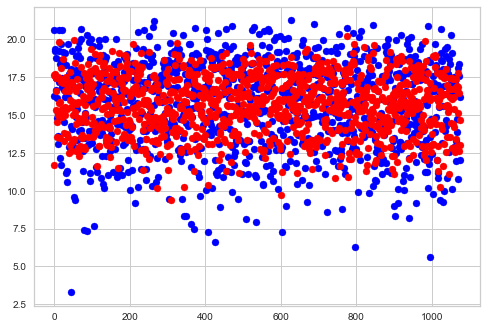

In [199]:
#Plotting

plt.scatter(range(len(y_test)), y_test, color='blue')
plt.scatter(range(len(y_hat_test)), y_hat_test, color='red')

### Random Forest conclusion

The mean absolute error of the Random forest model was 11.2 whereas the R2 was 0.76 suggesting that the model is predicting the y in the train data set fairly accurately.

### KNN

In [200]:
#Hyper parameter tuning for KNN - Viktor

#Define grid for k values and different metrics

# k grid values 
k_grid = [x for x in range(1, 50)]
# distance metric values
metrics_grid = ["minkowski", "cosine", "euclidean"]

# create all combinations of hyperparameters
hyperparameters_combos = []
for k in k_grid:
    for m in metrics_grid:
        hyperparameters_combos.append( (k, m) )
hyperparameters_combos

[(1, 'minkowski'),
 (1, 'cosine'),
 (1, 'euclidean'),
 (2, 'minkowski'),
 (2, 'cosine'),
 (2, 'euclidean'),
 (3, 'minkowski'),
 (3, 'cosine'),
 (3, 'euclidean'),
 (4, 'minkowski'),
 (4, 'cosine'),
 (4, 'euclidean'),
 (5, 'minkowski'),
 (5, 'cosine'),
 (5, 'euclidean'),
 (6, 'minkowski'),
 (6, 'cosine'),
 (6, 'euclidean'),
 (7, 'minkowski'),
 (7, 'cosine'),
 (7, 'euclidean'),
 (8, 'minkowski'),
 (8, 'cosine'),
 (8, 'euclidean'),
 (9, 'minkowski'),
 (9, 'cosine'),
 (9, 'euclidean'),
 (10, 'minkowski'),
 (10, 'cosine'),
 (10, 'euclidean'),
 (11, 'minkowski'),
 (11, 'cosine'),
 (11, 'euclidean'),
 (12, 'minkowski'),
 (12, 'cosine'),
 (12, 'euclidean'),
 (13, 'minkowski'),
 (13, 'cosine'),
 (13, 'euclidean'),
 (14, 'minkowski'),
 (14, 'cosine'),
 (14, 'euclidean'),
 (15, 'minkowski'),
 (15, 'cosine'),
 (15, 'euclidean'),
 (16, 'minkowski'),
 (16, 'cosine'),
 (16, 'euclidean'),
 (17, 'minkowski'),
 (17, 'cosine'),
 (17, 'euclidean'),
 (18, 'minkowski'),
 (18, 'cosine'),
 (18, 'euclidean'),
 

In [201]:
#Defining an empty dataframe in the form of a dictionary to record the results - Code Adjusted from Riccardo's github

hyperparameter_tuning_results = {}

#Writing a for loop that compiles the error values for each combination of
#metric and no. of neighbors seperately 

for combo in hyperparameters_combos:            #From Ricardo's GitHub
    knn = KNeighborsRegressor(n_neighbors=combo[0], metric=combo[1])
    knn = knn.fit(x_train, y_train)
    y_hat_validation = knn.predict(x_valid)
    error = mean_absolute_error(y_valid, y_hat_validation)
    hyperparameter_tuning_results[combo] = {
        "error": error
    }

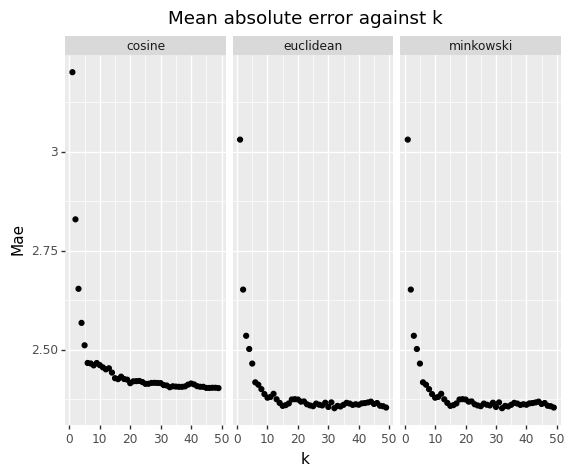

<ggplot: (153026239630)>

In [202]:
#Compiling the errors into a dataframe so ggplot can plot it - Code Adjusted from Riccardo's github

errors = []
for combo in hyperparameter_tuning_results:
    errors.append( (combo[0], combo[1], hyperparameter_tuning_results[combo]["error"]) )
errors_df = pd.DataFrame(errors, columns=["k", "metric", "error"])

#Plotting the results of each k for each metric 

(
    ggplot(errors_df, aes(x="k", y="error")) +
    geom_point() +
    facet_wrap("metric") +
    ggtitle("Mean absolute error against k") +
    ylab("Mae")
)

In [203]:
hyperparameter_tuning_results

{(1, 'minkowski'): {'error': 3.0308176324681986},
 (1, 'cosine'): {'error': 3.201205376740115},
 (1, 'euclidean'): {'error': 3.0308176324681986},
 (2, 'minkowski'): {'error': 2.6517623223852542},
 (2, 'cosine'): {'error': 2.8293030052821044},
 (2, 'euclidean'): {'error': 2.6517623223852542},
 (3, 'minkowski'): {'error': 2.5349716060199023},
 (3, 'cosine'): {'error': 2.653766356053933},
 (3, 'euclidean'): {'error': 2.5349716060199023},
 (4, 'minkowski'): {'error': 2.501578859482756},
 (4, 'cosine'): {'error': 2.567650162646321},
 (4, 'euclidean'): {'error': 2.501578859482756},
 (5, 'minkowski'): {'error': 2.464745291627975},
 (5, 'cosine'): {'error': 2.510956034319159},
 (5, 'euclidean'): {'error': 2.464745291627975},
 (6, 'minkowski'): {'error': 2.4173530588605465},
 (6, 'cosine'): {'error': 2.4663127135878216},
 (6, 'euclidean'): {'error': 2.4173530588605465},
 (7, 'minkowski'): {'error': 2.4112908814981227},
 (7, 'cosine'): {'error': 2.4649998097524066},
 (7, 'euclidean'): {'error': 

In [204]:
#Identifying the best(most accurate) combination of k and the enderlying metric - Code adjusted from Ricardo's GitHub

best_combo = None
lowest_error = 4
for combo in hyperparameter_tuning_results:
    error = hyperparameter_tuning_results[combo]['error']
    if error <= lowest_error:
        lowest_error = error
        best_combo = combo
lowest_error
best_combo

2.3519056397544738

(32, 'euclidean')

In [205]:
#Final knn model
knn_model = KNeighborsRegressor(n_neighbors=best_combo[0],metric = best_combo[1]) #Identifying hyper paramters from previous tuning
_ = knn_model.fit(x_train_valid,y_train_valid) #Fitting the training data
y_hat_test = knn_model.predict(x_test) #Predicting on test data
mean_absolute_error(y_test,y_hat_test) #Generating the result as a mae

2.3265308138352374

In [206]:
from sklearn.metrics import r2_score
r2_score(y_test,y_hat_test)

0.07458997940168544

In [207]:
np.exp(0.09785360376421537)

1.1028013273272514

Text(0.5, 1.0, 'Actual(Blue) vs Predicted(Red)')

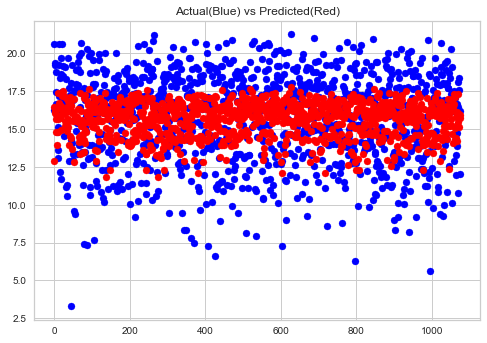

In [208]:
#Plotting the difference
plt.scatter(range(len(y_test)), y_test, color='blue')
plt.scatter(range(len(y_hat_test)), y_hat_test, color='red')
plt.title('Actual(Blue) vs Predicted(Red)')

In [210]:
mean_absolute_error(y_test,y_hat_test)

2.3265308138352374


### kNN Conclusion:
KNN however achieved an mae of 12.34 and an r2 of 1.1 which signifies that this particular model is a bad fit for a regression problem with these features and y.

In [211]:
#"Exponentializing" the result to return the normal value

print("Mean absolute error of the model is: ",np.exp(mean_absolute_error(y_test,y_hat_test)))

Mean absolute error of the model is:  10.242347217826596


### Reflection on this project (Viktor):

What would I do differently next time?
In terms of validation, a simple one fold validation is not sufficient with a limited dataset based on highly qualitative data (i.e. genres and movie lenght group). Instead a cross validation method should be applied in a scenario where the dataset is both limited in size and easily interpretable features. I believe this would result in a more accurate model with more consistent results. 

Reflection on personal growth:
During this project I felt that all of my previous knowledge in terms of python was put to a decisive test. Being able to create a working ML model from scratch felt satisfying and opened up my eyes to the world of AI. Having to take multiple factors into account at all of the stages of the process (EDA, Feature engineering, Data splitting, Model validation and finally predicting) was a challenge. Although creating a working model is not that complex; making a model that solves a real life problem is a tall task. Not even touching on the "interpretability factor". Hence, after this project I even more appreciate the use of ML that I come in contact and make use of in my personal life (e.g. Spotify ML generated playlists, Smart Google Translation etc.). Although difficult, I am motivated to increase my proficiency in this field whether it's only coding or Machine learning.

Team members reflection:
Ward was highly autonomous when working on his part. After a short while he presented us with an almost working model that just required a few fixes that he asked my help for. He was quick to implement any changes we required and highly proactive. I feel like if Ward keeps walking down his path he will be an excelent coder and data analyst.

Melanie was certainly in charge of organizing. She sctructured the work flow and made good calls of our next courses of action. She did require some help when it came to the more technical tasks like coding. Melanie was quick to learn however and she was making large steps along the learning curve as the project progressed. 

Guido was someone I felt comfortable approaching if I needed encouragement in terms of motivation as well as help with my code. He helped me solved syntax for a few for loops where I was completely stuck after countless google searches with no solution in sight. Guido has more of a slow and steady approach when it comes to projects, an approach that is fruitful if other team members are on the same wave lenght. 